In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# Genetic algorithm for hyperparameter optimization on the mnist dataset.
Credits: https://github.com/guibacellar/OpenAi/blob/master/CartPole-GA.py

In [3]:
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense, Dropout, InputLayer
from keras import backend as K
from keras.utils import to_categorical
from matplotlib import pyplot
import ipywidgets

# pyplot.style.use(['dark_background'])

2023-07-03 11:05:27.842279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 11:05:27.927664: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
# local imports
from gahyparopt.gahyperopt import *

In [5]:
# Define Hyperparameters for NN
HIDDEN_LAYER_COUNT = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
HIDDEN_LAYER_NEURONS = [8, 16, 24, 32, 64, 128, 256, 512]
HIDDEN_LAYER_RATE = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
HIDDEN_LAYER_ACTIVATIONS = ['relu', 'tanh', 'sigmoid']
HIDDEN_LAYER_TYPE = ['dense', 'dropout']
MODEL_OPTIMIZER = ['rmsprop', 'adams', 'sgd']

# Define Genetic Algorithm Parameters
MAX_GENERATIONS = 100  # Max Number of Generations to Apply the Genetic Algorithm
POPULATION_SIZE = 8  # Max Number of Individuals in Each Population
BEST_CANDIDATES_COUNT = 2  # Number of Best Candidates to Use
RANDOM_CANDIDATES_COUNT = 1  # Number of Random Candidates (From Entire Population of Generation) to Next Population
OPTIMIZER_MUTATION_PROBABILITY = 0.3  # 10% of Probability to Apply Mutation on Optimizer Parameter
HIDDEN_LAYER_MUTATION_PROBABILITY = 0.4  # 10% of Probability to Apply Mutation on Hidden Layer Quantity

In [6]:
ga = GADriver(layer_counts=HIDDEN_LAYER_COUNT,
                     no_neurons=HIDDEN_LAYER_NEURONS,
                     rates=HIDDEN_LAYER_RATE,
                     activations=HIDDEN_LAYER_ACTIVATIONS,
                     layer_types=HIDDEN_LAYER_TYPE,
                     optimizers=MODEL_OPTIMIZER,
                     population_size=POPULATION_SIZE,
                     best_candidates_count=BEST_CANDIDATES_COUNT,
                     random_candidates_count=RANDOM_CANDIDATES_COUNT,
                     optimizer_mutation_probability=OPTIMIZER_MUTATION_PROBABILITY,
                     layer_mutation_probability=HIDDEN_LAYER_MUTATION_PROBABILITY,
                    )

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [8]:
# Get test and training data.
data = load_mnist()

In [9]:
@ipywidgets.interact(i=ipywidgets.IntSlider(min=0, max=40000-1, step=100, value=0))
def plot_mnist_figure(i):
    print(data['y_train'][i])
    pyplot.imshow(data['x_train'][i].reshape(28,28), cmap='bone_r')

interactive(children=(IntSlider(value=0, description='i', max=39999, step=100), Output()), _dom_classes=('widg…

In [10]:
def generate_reference_ml(data):
    """
    Train and Generate NN Model based on https://github.com/fchollet/deep-learning-with-python-notebooks/blobs/master/2.1-a-first-look-at-a-neural-netword.ipynb'
    :param df: Dataframe to Training Process
    :return:
    """
    print("[+] Training Original NN Model: ", end='')
    run_start = time.time()

    # Define Neural model Topology
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(28 * 28,)))
    model.add(Dense(10, activation='softmax'))

    # Compile Neural model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Fit Model with Data
    x_train, y_train, x_val, y_val = data.values()
    training = model.fit(x_train, y_train,
        epochs=20,
        batch_size=128,
        steps_per_epoch=300,
        verbose=1,
        validation_data=(x_val, y_val),
    )

    run_stop = time.time()
    print(f"Done > Takes {run_stop-run_start} sec")

    return model, training


In [11]:
# Creates a Reference NN Model based on 
ml_model, training = generate_reference_ml(data)

[+] Training Original NN Model: 

2023-07-03 11:05:30.365687: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 11:05:30.913172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9383 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


2023-07-03 11:05:32.491163: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb14401bea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-03 11:05:32.491223: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-07-03 11:05:32.505475: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-03 11:05:32.621049: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-03 11:05:32.672885: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 [==============================] - 4s 8ms/step - loss: 0.3254 - accuracy: 0.9062 - val_loss: 0.1791 - val_accuracy: 0.9487
Epoch 2/20
300/300 [==============================] - 2s 8ms/step - loss: 0.1349 - accuracy: 0.9610 - val_loss: 0.1323 - val_accuracy: 0.9600
Epoch 3/20
300/300 [==============================] - 2s 7ms/step - loss: 0.0910 - accuracy: 0.9732 - val_loss: 0.1059 - val_accuracy: 0.9692
Epoch 4/20
300/300 [==============================] - 2s 7ms/step - loss: 0.0663 - accuracy: 0.9810 - val_loss: 0.0949 - val_accuracy: 0.9714
Epoch 5/20
300/300 [==============================] - 2s 7ms/step - loss: 0.0480 - accuracy: 0.9860 - val_loss: 0.0898 - val_accuracy: 0.9735
Epoch 6/20
300/300 [==============================] - 2s 7ms/step - loss: 0.0353 - accuracy: 0.9900 - val_loss: 0.0901 - val_accuracy: 0.9749
Epoch 7/20
300/300 [==============================] - 2s 7ms/step - loss: 0.0276 - accuracy: 0.9924 - val_loss: 0.0904 - val_accuracy: 0.9758
Epoch 8/20
300/30

In [12]:
from tensorflow.keras.utils import plot_model

In [13]:
plot = plot_model(ml_model, show_shapes=True, )

In [14]:
type(plot)

IPython.core.display.Image

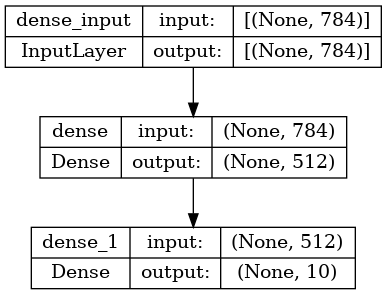

In [15]:
display(plot)

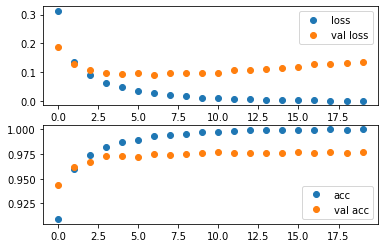

In [14]:
history = pd.DataFrame(training.history)

fig, ax = pyplot.subplots(2,1)
history['loss'].plot(ax=ax[0], style="o",label='loss')
history['val_loss'].plot(ax=ax[0], style="o",label='val loss')
ax[0].legend()
history['accuracy'].plot(ax=ax[1], style="o",label='acc')
history['val_accuracy'].plot(ax=ax[1], style="o",label='val acc')
ax[1].legend()

In [10]:
# Play Games with Reference NN Model
print("[+] Evaluate reference model \t>", end='', flush=True)
loss, accuracy  = evaluate_model(ml_model=ml_model, x = data['x_val'], y=data['y_val'])
print(f"\tAccuracy:{accuracy} | Loss:{loss} |")

625/625 [==============================] - 2s 2ms/step - loss: 0.1412 - accuracy: 0.9759
	Accuracy:0.9758999943733215 | Loss:0.14124155044555664 |


In [11]:
# >>>>>> Genetic Algorithm Section <<<<<<
print("\n********** Genetic Algorithm **********")
population = ga.generate_first_population_randomly()


********** Genetic Algorithm **********
[+] Creating Initial NN Model Population Randomly: Done > Takes 0.0002484321594238281 sec


In [12]:
len(population)

5

In [14]:
# Run Each Generation
generation_performance = {}
for current_generation in range(MAX_GENERATIONS):
    print(f"[+] Generation {current_generation+1} of {MAX_GENERATIONS}")

    # >>>>>> Training Phase <<<<<<
    print(f"\tTraining Models:", end='\n', flush=True)
    training_start = time.time()

    # Train all Models in Population
    for i,individual in enumerate(population):
        print(f"\t\tGenerating model for individual {i}", end='\n', flush=True)
        ga.generate_model_from_chromosome(data, individual)

    training_stop = time.time()
    print(f"Done > Takes {training_stop - training_start} sec", end='\n')

    # >>>>>> Evaluation Phase <<<<<<
    print(f"\tEvaluating Population: ", end='\n', flush=True)
    evaluation_start = time.time()

    for i,individual in enumerate(population):
        
        print(f"\t\tIndividual {i}", end='\n', flush=True)
        
        # Play the Games
        loss, accuracy =  individual.ml_model.evaluate(x=data['x_val'], y=data['y_val']) 
        
        # Update Chromosome Results
        individual.loss = loss
        individual.accuracy = accuracy
        

    evaluation_stop = time.time()
    print(f"Done > Takes {evaluation_stop - evaluation_start} sec", end='\n')

    # Sort Candidates by Sum of Results
    population.sort(key=lambda x: x.accuracy, reverse=True)

    # Compute Generation Metrics
    generation_performance[current_generation] = pd.DataFrame([{'loss':x.loss, 'accuracy': x.accuracy} for x in population ])
    
    generation_performance[current_generation].describe()

    # >>>>>> Genetic Selection, Children Creation and Mutation <<<<<<
    if current_generation < MAX_GENERATIONS-1:
        population = ga.evolve_population(population)

[+] Generation 1 of 100
	Training Models:
		Generating model for individual 0
		Generating model for individual 1
		Generating model for individual 2
		Generating model for individual 3
		Generating model for individual 4
Done > Takes 68.8868579864502 sec
	Evaluating Population: 
		Individual 0
625/625 [==============================] - 1s 2ms/step - loss: 0.2013 - accuracy: 0.9431
		Individual 1
625/625 [==============================] - 2s 3ms/step - loss: 1.0833 - accuracy: 0.6234
		Individual 2
625/625 [==============================] - 2s 3ms/step - loss: 1.7675 - accuracy: 0.5201
		Individual 3
625/625 [==============================] - 1s 2ms/step - loss: 2.3024 - accuracy: 0.1000
		Individual 4
625/625 [==============================] - 1s 2ms/step - loss: 2.3016 - accuracy: 0.1089
Done > Takes 7.984793424606323 sec
[+] Generation 2 of 100
	Training Models:
		Generating model for individual 0
		Generating model for individual 1
		Generating model for individual 2
		Generating m

KeyboardInterrupt: 